## Week 11 notebook

For Week 11, include concepts such as density-based spatial clustering of applications with noise (DBSCAN), hierarchical agglomerative clustering (HAC), linkage methods in HAC, and dendrograms. Complete your Jupyter Notebook homework by 11:59pm ET on Sunday. 

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.cluster.hierarchy import dendrogram, linkage

# Import feature engineering and selection libraries
from sklearn.cluster import DBSCAN, AgglomerativeClustering
from sklearn.neighbors import NearestNeighbors

# data preprocesing
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, MinMaxScaler

# Clustering metrics
from sklearn.metrics import silhouette_score, calinski_harabasz_score, davies_bouldin_score

pd.set_option('display.max_columns', None)
random_state = 0

In [2]:
def encoding(df_or_series, cat_cols: list = None, one_hot: bool = False):
    """
    Encodes categorical columns in a DataFrame or a single pandas Series.

    Args:
        df_or_series: DataFrame or Series to encode.
        cat_cols: List of columns to encode (only used if input is DataFrame).
        one_hot: If True, use one-hot encoding for DataFrame input.

    Returns:
        If input is DataFrame: (encoded DataFrame, mappings dict or list of new columns)
        If input is Series: (encoded Series, mapping dict)
    """
    if isinstance(df_or_series, pd.Series):
        uniques = df_or_series.dropna().unique().tolist()
        mapping = {cat: code for code, cat in enumerate(uniques)}
        encoded = df_or_series.map(mapping).astype("int64")
        return encoded
    
    elif isinstance(df_or_series, pd.DataFrame):
        if one_hot:
            if cat_cols is None:
                cat_cols = df_or_series.select_dtypes(include=['object', 'category']).columns.tolist()
            df_encoded = pd.get_dummies(df_or_series, columns=cat_cols, drop_first=True)
            return df_encoded
        else:
            df_encoded = df_or_series.copy()
            mappings = {}
            if cat_cols is None:
                cat_cols = df_encoded.select_dtypes(include=['object', 'category']).columns.tolist()
            for col in cat_cols:
                uniques = df_encoded[col].dropna().unique().tolist()
                mapping = {cat: code for code, cat in enumerate(uniques)}
                mappings[col] = mapping
                df_encoded[col] = df_encoded[col].map(mapping).astype("int64")
            return df_encoded
    
    else:
        raise ValueError("Input must be a pandas DataFrame or Series.")

In [3]:
def load_and_split_data(file_path: str, target_col: str = None, one_hot: bool = False, test_size: float = 0.2, random_state: int = 0, scaling: str = 'norm'):
    """
    Loads data, encodes categorical features, splits into train/test, and scales features.

    Args:
        file_path: Path to CSV file.
        target_col: Name of target column. If None, uses last column.
        test_size: Fraction for test split.
        random_state: Random seed.
        scaling: 'norm' (MinMax), 'reg' (Standard), or None.

    Returns:
        X_train, X_test, y_train, y_test, df, mappings
    """
    df = pd.read_csv(file_path)
    
    # Select target
    if target_col is None:
        target_col = df.columns[-1]
    X = df.drop(columns=[target_col])
    y = df[target_col]

    # Encode Categorical Features
    if one_hot is True:
        X_encoded = encoding(X, one_hot=True)
        if y.dtype == 'object' or y.dtype.name == 'category':
            y_encoded = encoding(y)
        else:
            y_encoded = y
    else:
        X_encoded = encoding(X)
        if y.dtype == 'object' or y.dtype.name == 'category':
            y_encoded = encoding(y)
        else:
            y_encoded = y
            
        

    # Split
    X_train, X_test, y_train, y_test = train_test_split(
        X_encoded, y_encoded, test_size=test_size, random_state=random_state
    )

    # Reset indices
    X_train = X_train.reset_index(drop=True)
    X_test = X_test.reset_index(drop=True)
    y_train = y_train.reset_index(drop=True)
    y_test = y_test.reset_index(drop=True)

    # Scaling
    if scaling == 'reg':
        scaler = StandardScaler()
    elif scaling == 'norm':
        scaler = MinMaxScaler()
    else:
        scaler = None

    if scaler is not None:
        X_train = pd.DataFrame(scaler.fit_transform(X_train), columns=X_train.columns)
        X_test = pd.DataFrame(scaler.transform(X_test), columns=X_test.columns)

    return X_train, X_test, y_train, y_test, df


In [4]:
def clustering_model(data_used, method, X_data, **model_params):
    """
    Function to fit and evaluate clustering models with comprehensive metrics.

    Args:
        data_used: String indicating the dataset used (for logging purposes).
        method: Clustering method (e.g., DBSCAN, AgglomerativeClustering).
        X_data: Feature data for clustering.
        model_params: Additional parameters for model.

    Returns:
        model: The fitted clustering model.
        cluster_labels: The cluster assignments.
        results: Dictionary of results including various metrics.
    """
    
    # Create and fit the clustering model
    model = method(**model_params)
    cluster_labels = model.fit_predict(X_data)
    model_name = model.__class__.__name__
    
    # Count clusters and noise points
    unique_labels = set(cluster_labels)
    n_clusters = len(unique_labels) - (1 if -1 in cluster_labels else 0)
    n_noise = list(cluster_labels).count(-1)
    n_points = len(cluster_labels)
    
    print(f"\n{model_name} Clustering Results for {data_used}:")
    print(f"Number of clusters: {n_clusters}")
    print(f"Number of noise points: {n_noise}")
    print(f"Percentage of noise: {(n_noise/n_points)*100:.2f}%")
    print(f"Points in clusters: {n_points - n_noise}")
    
    # Initialize results dictionary
    results = {
        'data_used': data_used,
        'model_name': model_name,
        'model_params': model.get_params(),
        'n_clusters': n_clusters,
        'n_noise': n_noise,
        'noise_percentage': (n_noise/n_points)*100,
        'cluster_labels': cluster_labels
    }
    
    # Calculate internal validation metrics (only for non-noise points)
    if n_clusters > 1:
        # Filter out noise points for internal metrics
        mask = cluster_labels != -1
        X_filtered = X_data[mask]
        labels_filtered = cluster_labels[mask]
        
        if len(X_filtered) > 0 and len(set(labels_filtered)) > 1:
            # Silhouette Score
            try:
                sil_score = silhouette_score(X_filtered, labels_filtered)
                results['silhouette_score'] = sil_score
                print(f"Silhouette Score: {sil_score:.4f}")
            except Exception as e:
                print(f"Could not calculate Silhouette Score: {e}")
                results['silhouette_score'] = None
            
            # Calinski-Harabasz Index (higher is better)
            try:
                ch_score = calinski_harabasz_score(X_filtered, labels_filtered)
                results['calinski_harabasz_score'] = ch_score
                print(f"Calinski-Harabasz Score: {ch_score:.4f}")
            except Exception as e:
                print(f"Could not calculate Calinski-Harabasz Score: {e}")
                results['calinski_harabasz_score'] = None
            
            # Davies-Bouldin Index (lower is better)
            try:
                db_score = davies_bouldin_score(X_filtered, labels_filtered)
                results['davies_bouldin_score'] = db_score
                print(f"Davies-Bouldin Score: {db_score:.4f}")
            except Exception as e:
                print(f"Could not calculate Davies-Bouldin Score: {e}")
                results['davies_bouldin_score'] = None
        else:
            print("Not enough clusters or points for internal validation metrics.")
            results['silhouette_score'] = None
            results['calinski_harabasz_score'] = None
            results['davies_bouldin_score'] = None
    else:
        print("Only one cluster found - cannot calculate internal validation metrics.")
        results['silhouette_score'] = None
        results['calinski_harabasz_score'] = None
        results['davies_bouldin_score'] = None
    
    # Cluster size distribution
    if n_clusters > 0:
        cluster_sizes = {}
        for label in unique_labels:
            if label != -1:  # Exclude noise
                cluster_sizes[f'cluster_{label}'] = list(cluster_labels).count(label)
        
        results['cluster_sizes'] = cluster_sizes
        print(f"\nCluster sizes: {cluster_sizes}")
    
    print("-" * 50)
    
    return model, cluster_labels, results

In [5]:
# Load the ins claims dataset with variations of encoding and scaling
X_train_ins_oh_reg, X_test_ins_oh_reg, y_train_ins_oh_reg, y_test_ins_oh_reg, df_ins_oh_reg = load_and_split_data(
    r'C:\Users\JT von Seggern\DS Masters Repos\2025-spring-B2\data\insurance_claims_cleaned.csv', 
    target_col='fraud_reported', one_hot=False, scaling='reg')

# Load the car claims dataset with variations of encoding and scaling
X_train_car_oh_reg, X_test_car_oh_reg, y_train_car_oh_reg, y_test_car_oh_reg, df_car_oh_reg = load_and_split_data(
    r'C:\Users\JT von Seggern\DS Masters Repos\2025-spring-B2\data\carclaims_cleaned.csv', 
    target_col='FraudFound', one_hot=False, scaling='reg')

## Insurance claims

C:\Users\JT von Seggern\AppData\Local\Temp\ipykernel_36460\3003182340.py:22: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')


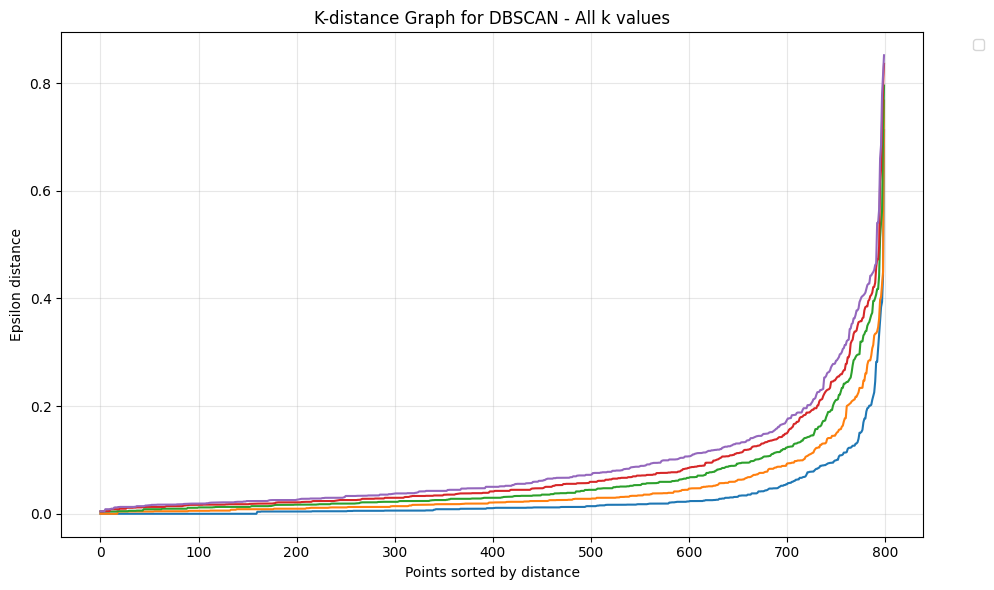

In [6]:
# Create a single figure for all k-distance plots
plt.figure(figsize=(10, 6))

for i in range(2, 7):

    # Run the Nearest Neighbors algorithm to find the optimal epsilon for DBSCAN
    neighbors_ins = NearestNeighbors(n_neighbors=i)
    neighbors_fit_ins = neighbors_ins.fit(X_train_ins_oh_reg[['vehicle_claim', 'property_claim']])

    # Find the distances and indices of the nearest neighbors
    distances_ins, indices_ins = neighbors_fit_ins.kneighbors(X_train_ins_oh_reg[['vehicle_claim', 'property_claim']])

    # Sort the distances to find the optimal epsilon
    distances_ins = np.sort(distances_ins, axis=0)
    distances_ins = distances_ins[:, i-1]
    # Add labels, title, and legend
    plt.plot(distances_ins)

plt.xlabel('Points sorted by distance')
plt.ylabel('Epsilon distance')
plt.title('K-distance Graph for DBSCAN - All k values')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

### DBSCAN

In [7]:
# DBSCAN clustering
dbscan_ins = DBSCAN(eps=.2, min_samples=5).fit(X_train_ins_oh_reg[['vehicle_claim', 'property_claim']])

# Extract the clusters labels
labels_ins = dbscan_ins.labels_

# Create a DataFrame to hold the clusters and the original data
clustered_ins = X_train_ins_oh_reg.copy()
clustered_ins['cluster'] = labels_ins

# Separate the cluster column from the rest
x_cluseterd_ins = clustered_ins[['vehicle_claim', 'property_claim']]
y_clustered_ins = clustered_ins['cluster']

# Display the first few rows of the clustered data
clustered_ins.head()

,months_as_customer,age,policy_state,policy_csl,policy_deductable,policy_annual_premium,umbrella_limit,insured_zip,insured_sex,insured_education_level,insured_occupation,insured_hobbies,insured_relationship,capital-gains,capital-loss,incident_type,collision_type,incident_severity,authorities_contacted,incident_state,incident_city,incident_hour_of_the_day,number_of_vehicles_involved,property_damage,bodily_injuries,witnesses,police_report_available,total_claim_amount,injury_claim,property_claim,vehicle_claim,auto_make,auto_model,auto_year,cluster
0,-0.094195,0.199690,1.219907,-1.185366,-1.021723,-0.209017,-0.489168,1.573417,-1.069940,1.446553,0.973397,1.326526,1.471630,0.960020,-0.855061,0.775659,0.419000,-0.210119,-1.270610,0.940682,0.042416,0.739671,1.139326,-0.043792,-1.211098,0.443634,-0.070821,1.646300,1.307162,2.720780,1.263562,-1.570687,-1.165930,-1.030921,-1
1,-1.749713,-1.097348,-1.183851,1.284146,-1.021723,-1.642830,-0.489168,1.569318,0.934632,1.446553,-1.542653,0.454242,-0.836809,0.949272,0.958258,-1.116192,-1.340582,-0.210119,-1.270610,-1.243776,1.584798,0.452560,-0.820805,-0.043792,1.223270,1.339864,-1.302488,1.299671,0.108737,3.366941,0.922620,1.402809,0.952940,-0.365945,-1
2,-1.029177,-1.529694,0.018028,-1.185366,-1.021723,0.017655,-0.489168,-0.855134,0.934632,1.446553,-0.536233,-0.941412,0.317410,1.479509,-0.936360,1.721584,-0.460791,1.917668,-0.602308,-1.243776,1.070670,-0.552331,-0.820805,1.207406,1.223270,0.443634,-0.070821,-1.788022,-1.324834,-1.340510,-1.810751,-0.331731,1.659230,-0.033457,0
3,0.206028,-0.232656,0.018028,1.284146,-0.200237,0.317038,-0.489168,-0.932922,0.934632,-0.047949,1.728212,-0.941412,1.471630,-0.920888,-0.999985,-1.116192,0.419000,0.853775,0.734297,-0.151547,-1.499967,0.739671,-0.820805,1.207406,-1.211098,0.443634,-1.302488,0.073345,0.527464,0.519275,-0.166586,-1.570687,-1.165930,-0.199701,1
4,0.386163,0.307776,0.018028,0.049390,-1.021723,-0.817514,-0.489168,-0.597316,-1.069940,0.450219,0.470187,0.454242,-1.413919,1.569076,-0.480379,-1.116192,0.419000,-1.274013,0.734297,-1.243776,-1.499967,0.596115,-0.820805,-0.043792,0.006086,-0.452596,-0.070821,0.843461,1.286535,-0.126887,0.878542,0.411643,1.394371,0.631520,2



DBSCAN Clustering Results for Insurance Claims:
Number of clusters: 7
Number of noise points: 50
Percentage of noise: 6.25%
Points in clusters: 750
Silhouette Score: 0.1770
Calinski-Harabasz Score: 578.7734
Davies-Bouldin Score: 1.1404

Cluster sizes: {'cluster_0': 144, 'cluster_1': 232, 'cluster_2': 325, 'cluster_3': 26, 'cluster_4': 13, 'cluster_5': 5, 'cluster_6': 5}
--------------------------------------------------


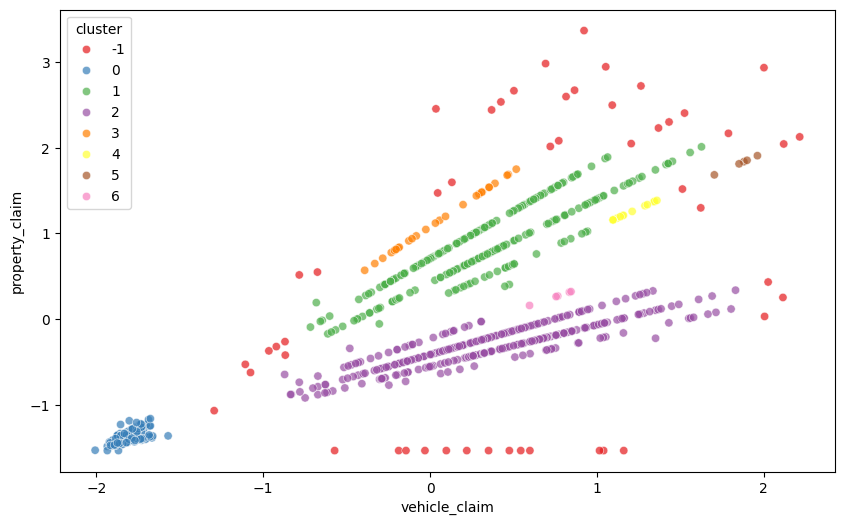

In [8]:
# Plot the results of the DBSCAN clustering
plt.figure(figsize=(10, 6))
sns.scatterplot(data=clustered_ins, x='vehicle_claim', y='property_claim', hue='cluster', palette='Set1', alpha=0.7)

# Params for clusting model
model_ins_params = {
    'eps': 0.2,
    'min_samples': 5
}

# Evaluate the clustering model
model_ins, cluster_labels_ins, results_ins = clustering_model(
    data_used='Insurance Claims',
    method=DBSCAN,
    X_data=x_cluseterd_ins,
    **model_ins_params
)

### HAC

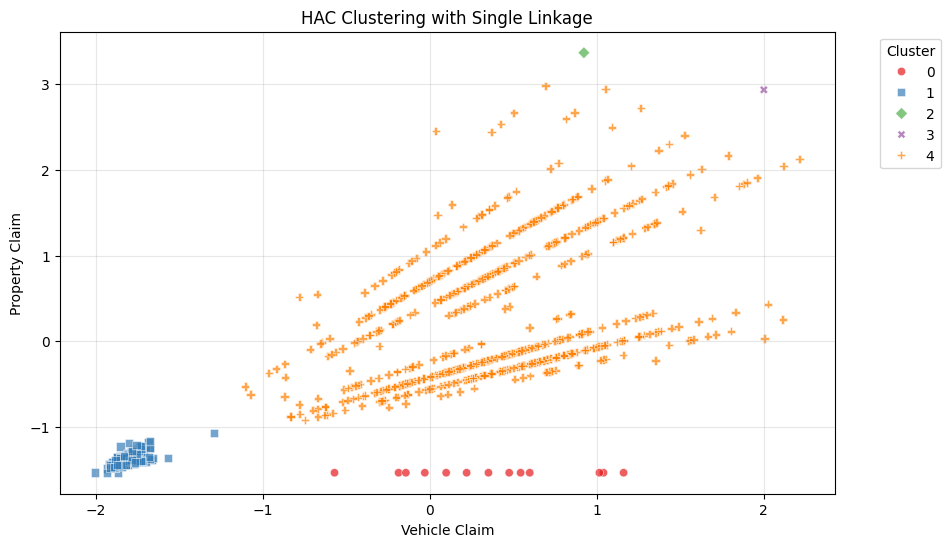

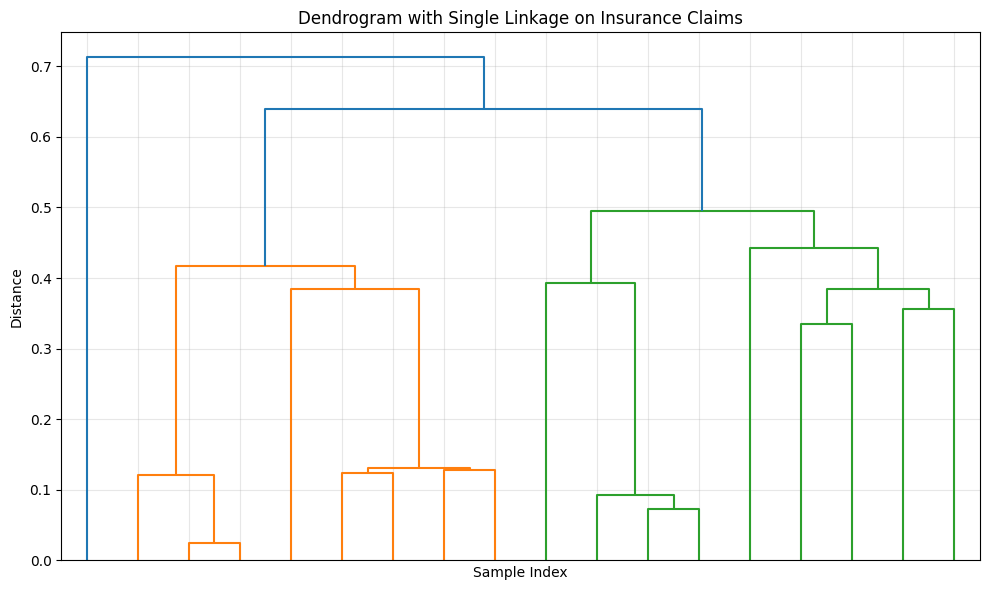

In [9]:
# HAC-single

# HAC clustering with different linkage methods
hac_single_ins = AgglomerativeClustering(n_clusters=5, linkage='single')
labels_single_ins = hac_single_ins.fit_predict(X_train_ins_oh_reg[['vehicle_claim', 'property_claim']])

# Plot the clusters
plt.figure(figsize=(10,6))
sns.scatterplot(X_train_ins_oh_reg, x='vehicle_claim', y='property_claim', hue=labels_single_ins, palette='Set1', style=labels_single_ins, markers=["o", "s", "D", "X", "P"], alpha=0.7)
plt.xlabel("Vehicle Claim")
plt.ylabel("Property Claim")
plt.title("HAC Clustering with Single Linkage")
plt.legend(title='Cluster', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.grid(True, alpha=0.3)
plt.show()

# Compute the linkage matrix
linkage_matrix_single_ins = linkage(X_train_ins_oh_reg[['vehicle_claim', 'property_claim']], method='single')

# Plot the dendrogram
plt.figure(figsize=(10, 6))
dendrogram(linkage_matrix_single_ins, truncate_mode='level', p=5)
plt.title("Dendrogram with Single Linkage on Insurance Claims")
plt.xlabel("Sample Index")
plt.xticks(visible=False)
plt.ylabel("Distance")
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

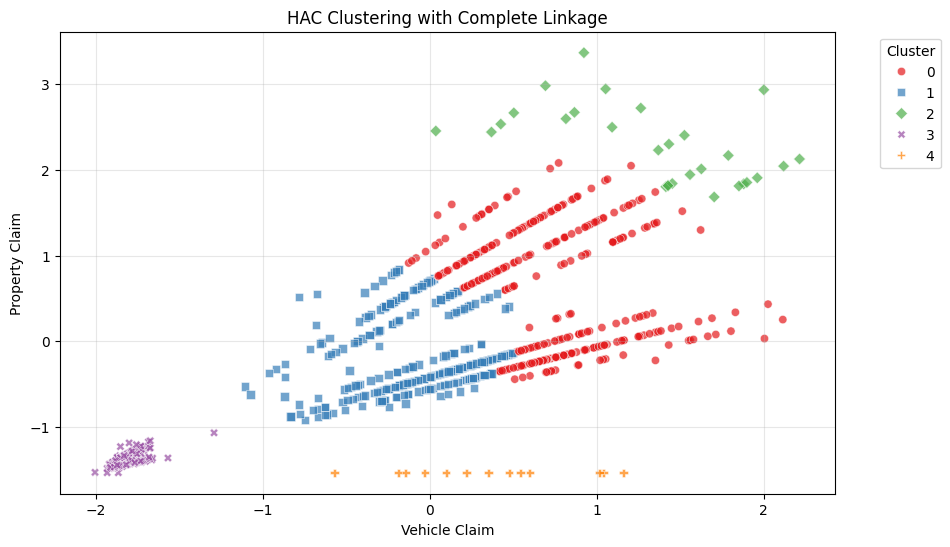

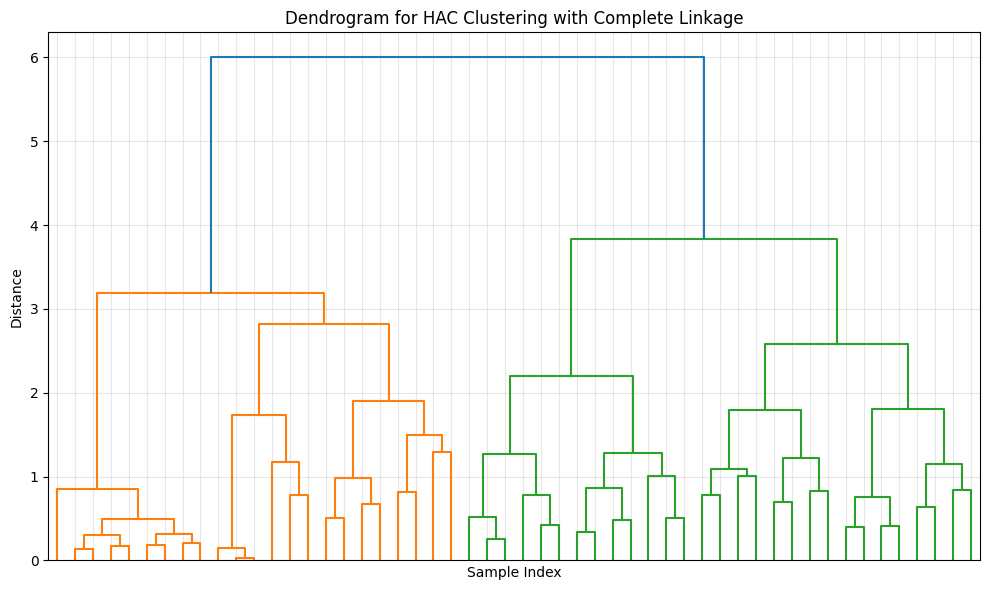

In [10]:
# HAC-complete

# HAC clustering with different linkage methods
hac_complete_ins = AgglomerativeClustering(n_clusters=5, linkage='complete')
labels_complete_ins = hac_complete_ins.fit_predict(X_train_ins_oh_reg[['vehicle_claim', 'property_claim']])

# Plot the clusters
plt.figure(figsize=(10,6))
sns.scatterplot(X_train_ins_oh_reg, x='vehicle_claim', y='property_claim', hue=labels_complete_ins, palette='Set1', style=labels_complete_ins, markers=["o", "s", "D", "X", "P"], alpha=0.7)
plt.xlabel("Vehicle Claim")
plt.ylabel("Property Claim")
plt.title("HAC Clustering with Complete Linkage")
plt.legend(title='Cluster', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.grid(True, alpha=0.3)
plt.show()

# Compute the linkage matrix
linkage_matrix_complete_ins = linkage(X_train_ins_oh_reg[['vehicle_claim', 'property_claim']], method='complete')

# Plot the dendrogram
plt.figure(figsize=(10, 6))
dendrogram(linkage_matrix_complete_ins, truncate_mode='level', p=5)
plt.title("Dendrogram for HAC Clustering with Complete Linkage")
plt.xlabel("Sample Index")
plt.xticks(visible=False)
plt.ylabel("Distance")
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

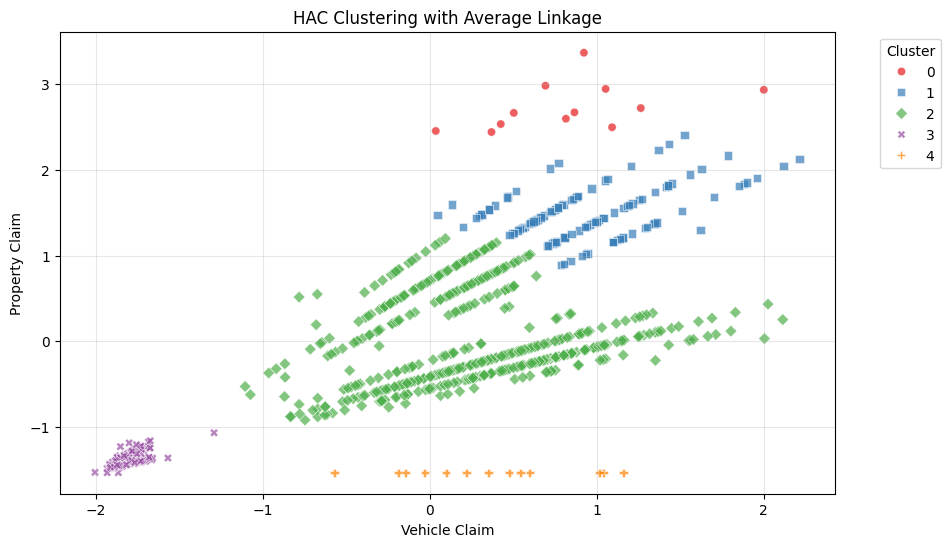

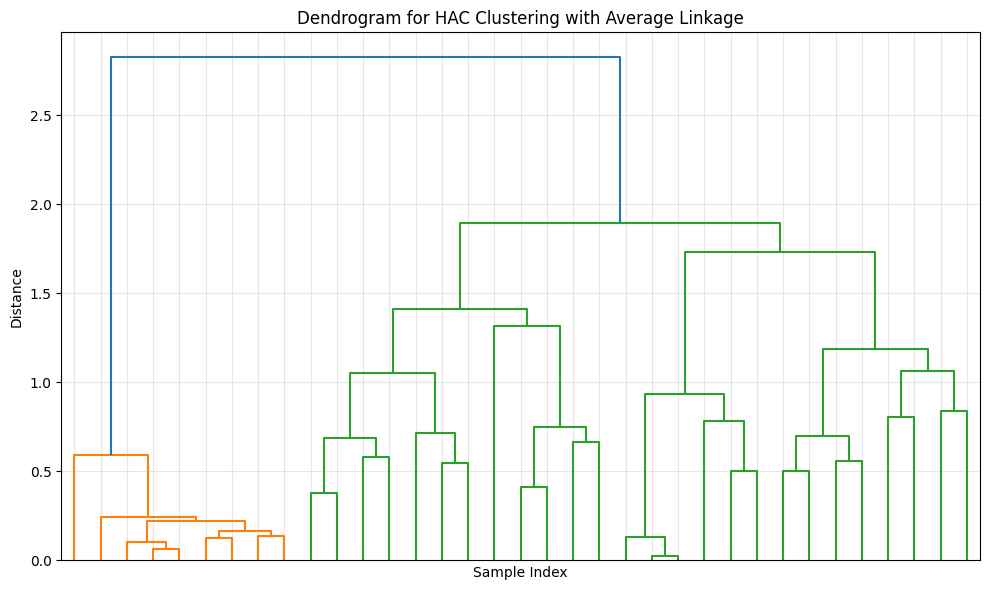

In [11]:
# HAC-average

# HAC clustering with different linkage methods
hac_average_ins = AgglomerativeClustering(n_clusters=5, linkage='average')
labels_average_ins = hac_average_ins.fit_predict(X_train_ins_oh_reg[['vehicle_claim', 'property_claim']])

# Plot the clusters
plt.figure(figsize=(10,6))
sns.scatterplot(X_train_ins_oh_reg, x='vehicle_claim', y='property_claim', hue=labels_average_ins, palette='Set1', style=labels_average_ins, markers=["o", "s", "D", "X", "P"], alpha=0.7)
plt.xlabel("Vehicle Claim")
plt.ylabel("Property Claim")
plt.title("HAC Clustering with Average Linkage")
plt.legend(title='Cluster', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.grid(True, alpha=0.3)
plt.show()

# Compute the linkage matrix
linkage_matrix_average_ins = linkage(X_train_ins_oh_reg[['vehicle_claim', 'property_claim']], method='average')

# Plot the dendrogram
plt.figure(figsize=(10, 6))
dendrogram(linkage_matrix_average_ins, truncate_mode='level', p=5)
plt.title("Dendrogram for HAC Clustering with Average Linkage")
plt.xlabel("Sample Index")
plt.xticks(visible=False)
plt.ylabel("Distance")
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

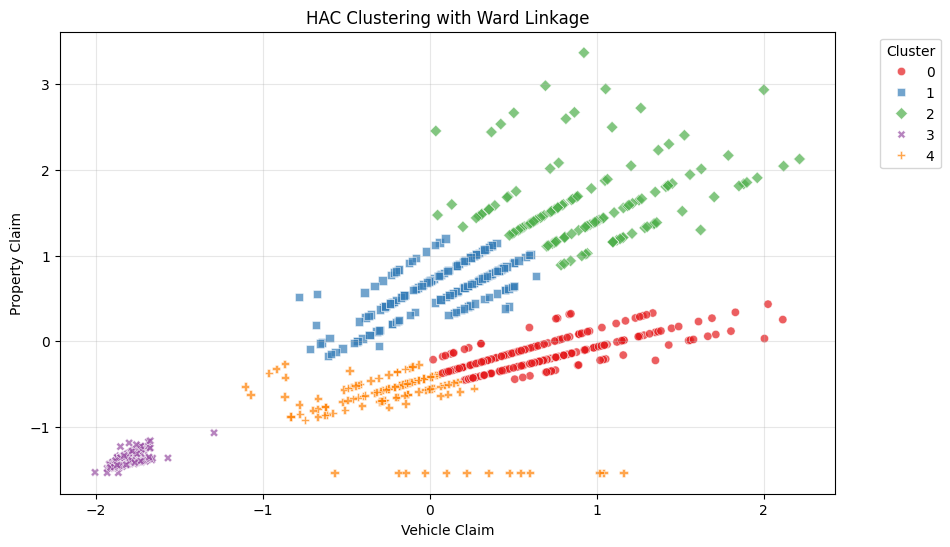

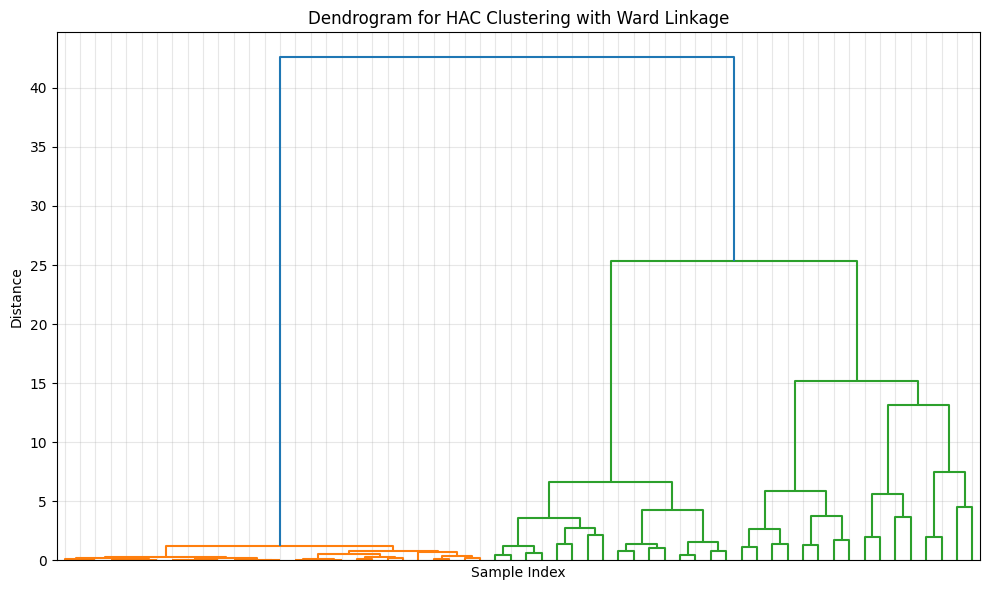

In [12]:
# HAC-ward

# HAC clustering with different linkage methods
hac_ward_ins = AgglomerativeClustering(n_clusters=5, linkage='ward')
labels_ward_ins = hac_ward_ins.fit_predict(X_train_ins_oh_reg[['vehicle_claim', 'property_claim']])

# Plot the clusters
plt.figure(figsize=(10,6))
sns.scatterplot(X_train_ins_oh_reg, x='vehicle_claim', y='property_claim', hue=labels_ward_ins, palette='Set1', style=labels_ward_ins, markers=["o", "s", "D", "X", "P"], alpha=0.7)
plt.xlabel("Vehicle Claim")
plt.ylabel("Property Claim")
plt.title("HAC Clustering with Ward Linkage")
plt.legend(title='Cluster', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.grid(True, alpha=0.3)
plt.show()

# Compute the linkage matrix
linkage_matrix_ward_ins = linkage(X_train_ins_oh_reg[['vehicle_claim', 'property_claim']], method='ward')

# Plot the dendrogram
plt.figure(figsize=(10, 6))
dendrogram(linkage_matrix_ward_ins, truncate_mode='level', p=5)
plt.title("Dendrogram for HAC Clustering with Ward Linkage")
plt.xlabel("Sample Index")
plt.xticks(visible=False)
plt.ylabel("Distance")
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

## Car Claims

C:\Users\JT von Seggern\AppData\Local\Temp\ipykernel_36460\4011238449.py:22: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')


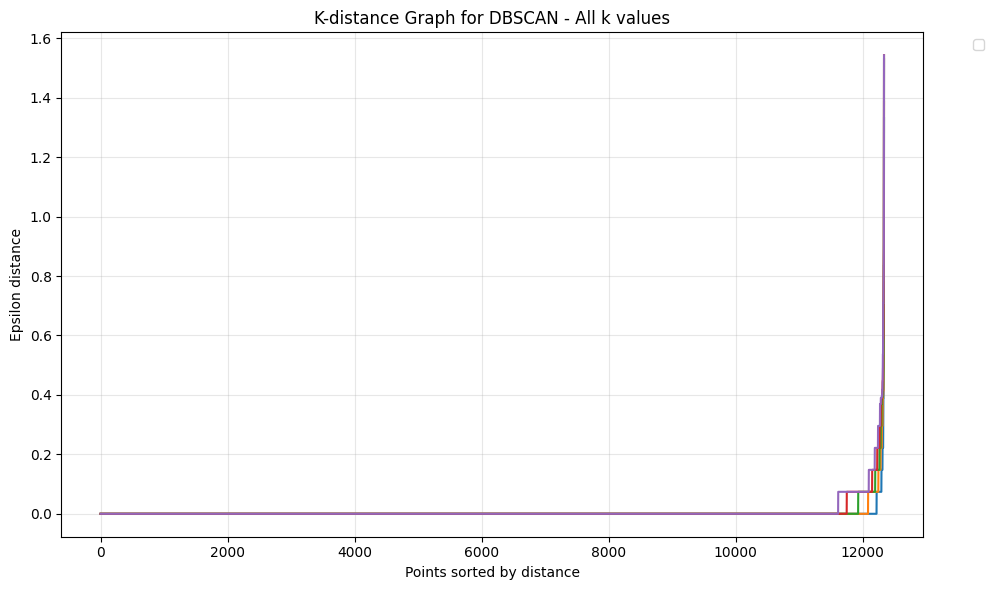

In [13]:
# Create a single figure for all k-distance plots
plt.figure(figsize=(10, 6))

for i in range(2, 7):

    # Run the Nearest Neighbors algorithm to find the optimal epsilon for DBSCAN
    neighbors_car = NearestNeighbors(n_neighbors=i)
    neighbors_fit_car = neighbors_car.fit(X_train_car_oh_reg[['Age', 'Make']])

    # Find the distances and indices of the nearest neighbors
    distances_car, indices_car = neighbors_fit_car.kneighbors(X_train_car_oh_reg[['Age', 'Make']])

    # Sort the distances to find the optimal epsilon
    distances_car = np.sort(distances_car, axis=0)
    distances_car = distances_car[:, i-1]
    # Add labels, title, and legend
    plt.plot(distances_car)

plt.xlabel('Points sorted by distance')
plt.ylabel('Epsilon distance')
plt.title('K-distance Graph for DBSCAN - All k values')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

In [14]:
# DBSCAN clustering
dbscan_car = DBSCAN(eps=.2, min_samples=5).fit(X_train_car_oh_reg[['Age', 'Make']])

# Extract the clusters labels
labels_car = dbscan_car.labels_

# Create a DataFrame to hold the clusters and the original data
clustered_car = X_train_car_oh_reg.copy()
clustered_car['cluster'] = labels_car

# Separate the cluster column from the rest
x_cluseterd_car = clustered_car[['Age', 'Make']]
y_clustered_car = clustered_car['cluster']

# Display the first few rows of the clustered data
clustered_car.head()

,Month,WeekOfMonth,DayOfWeek,Make,AccidentArea,DayOfWeekClaimed,MonthClaimed,WeekOfMonthClaimed,Sex,MaritalStatus,Age,Fault,PolicyType,VehicleCategory,VehiclePrice,RepNumber,Deductible,DriverRating,Days:Policy-Accident,Days:Policy-Claim,PastNumberOfClaims,AgeOfVehicle,AgeOfPolicyHolder,PoliceReportFiled,WitnessPresent,AgentType,NumberOfSuppliments,AddressChange-Claim,NumberOfCars,Year,BasePolicy,cluster
0,-1.569340,0.937266,-0.980833,-0.801681,-0.341441,0.068013,-0.132361,1.829458,0.432644,0.596341,0.753971,-0.606073,1.013683,0.761723,0.687817,0.324656,-0.173514,-1.325351,-0.096400,-0.068600,-1.300623,-0.301340,-0.366762,-0.170631,-0.077155,-0.12237,-0.006966,2.629359,3.509272,-1.075721,0.045467,0
1,0.164232,-1.384910,1.555442,-0.021195,-0.341441,1.424541,0.153895,0.243332,0.432644,-1.439205,-0.946324,-0.606073,1.013683,0.761723,0.687817,0.758846,-0.173514,0.461971,-0.096400,-0.068600,0.650786,-0.301340,-0.885850,-0.170631,-0.077155,-0.12237,0.888122,-0.193598,-0.089862,0.168195,0.045467,1
2,0.453161,0.163207,0.033677,-0.021195,-0.341441,-1.288514,-0.418617,0.243332,0.432644,0.596341,-0.207066,1.649967,1.013683,0.761723,-0.364118,-0.760817,-0.173514,1.355632,-0.096400,-0.068600,-1.300623,-0.301340,1.190503,-0.170631,-0.077155,-0.12237,-0.006966,-0.193598,-0.089862,0.168195,0.045467,1
3,-1.569340,0.937266,1.048187,-1.191924,-0.341441,-1.288514,-0.132361,1.036395,0.432644,0.596341,1.123600,-0.606073,-1.222644,-1.351301,0.687817,1.410129,-0.173514,-1.325351,13.651472,19.611699,-0.324918,0.562152,-0.366762,-0.170631,-0.077155,-0.12237,-0.902053,-0.193598,-0.089862,-1.075721,-1.232153,2
4,-1.569340,-0.610851,-0.473578,-0.801681,-0.341441,-0.610250,-0.132361,-0.549731,-2.311367,0.596341,-0.428843,-0.606073,-1.222644,-1.351301,-1.416054,1.193035,-0.173514,-1.325351,-0.096400,-0.068600,0.650786,1.425644,-0.885850,-0.170631,-0.077155,-0.12237,1.783210,-0.193598,-0.089862,-1.075721,-1.232153,0



DBSCAN Clustering Results for Car Claims:
Number of clusters: 29
Number of noise points: 149
Percentage of noise: 1.21%
Points in clusters: 12187
Silhouette Score: -0.0221
Calinski-Harabasz Score: 676.2905
Davies-Bouldin Score: 1.5047

Cluster sizes: {'cluster_0': 2502, 'cluster_1': 1874, 'cluster_2': 1981, 'cluster_3': 1291, 'cluster_4': 3078, 'cluster_5': 361, 'cluster_6': 65, 'cluster_7': 261, 'cluster_8': 297, 'cluster_9': 211, 'cluster_10': 50, 'cluster_11': 46, 'cluster_12': 18, 'cluster_13': 8, 'cluster_14': 18, 'cluster_15': 5, 'cluster_16': 10, 'cluster_17': 12, 'cluster_18': 5, 'cluster_19': 23, 'cluster_20': 6, 'cluster_21': 28, 'cluster_22': 5, 'cluster_23': 6, 'cluster_24': 5, 'cluster_25': 5, 'cluster_26': 5, 'cluster_27': 6, 'cluster_28': 5}
--------------------------------------------------


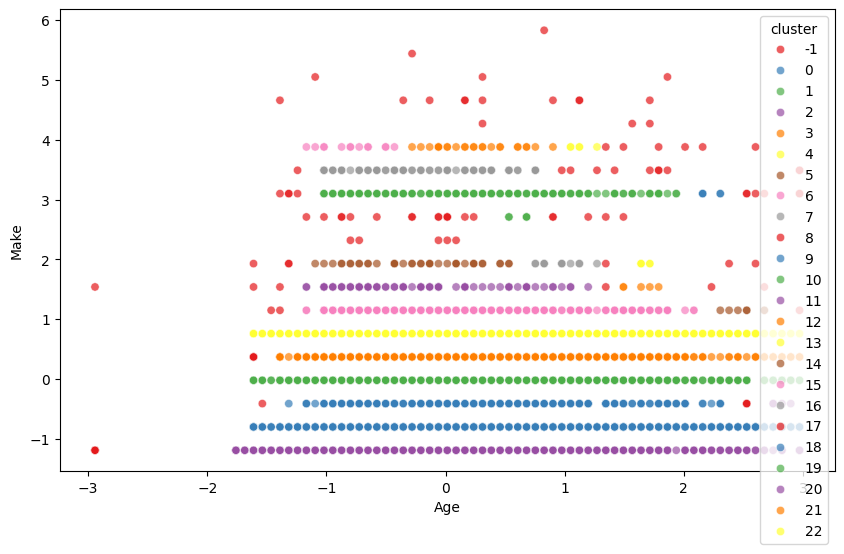

In [15]:
# Plot the results of the DBSCAN clustering
plt.figure(figsize=(10, 6))
sns.scatterplot(data=clustered_car, x='Age', y='Make', hue='cluster', palette='Set1', alpha=0.7)

# Params for clusting model
model_car_params = {
    'eps': 0.1,
    'min_samples': 5
}

# Evaluate the clustering model
model_car, cluster_labels_car, results_car = clustering_model(
    data_used='Car Claims',
    method=DBSCAN,
    X_data=x_cluseterd_car,
    **model_car_params
)

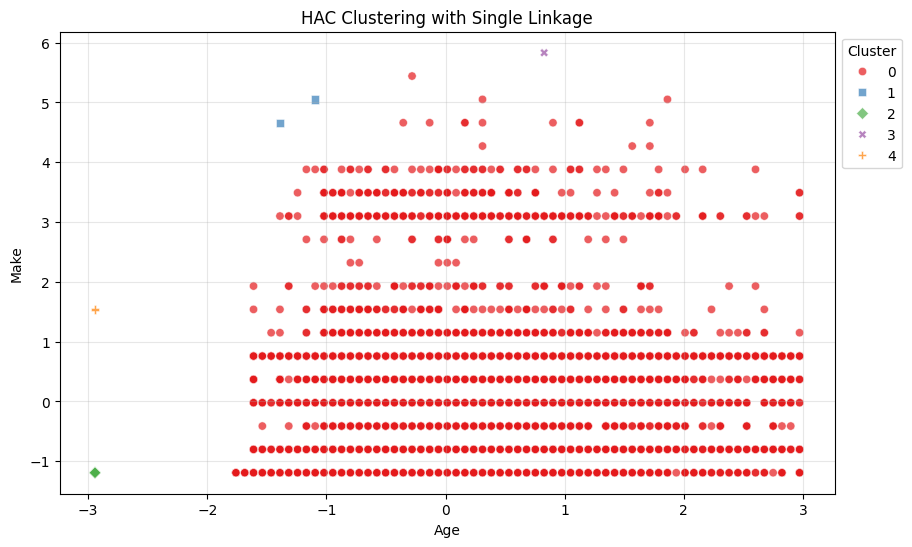

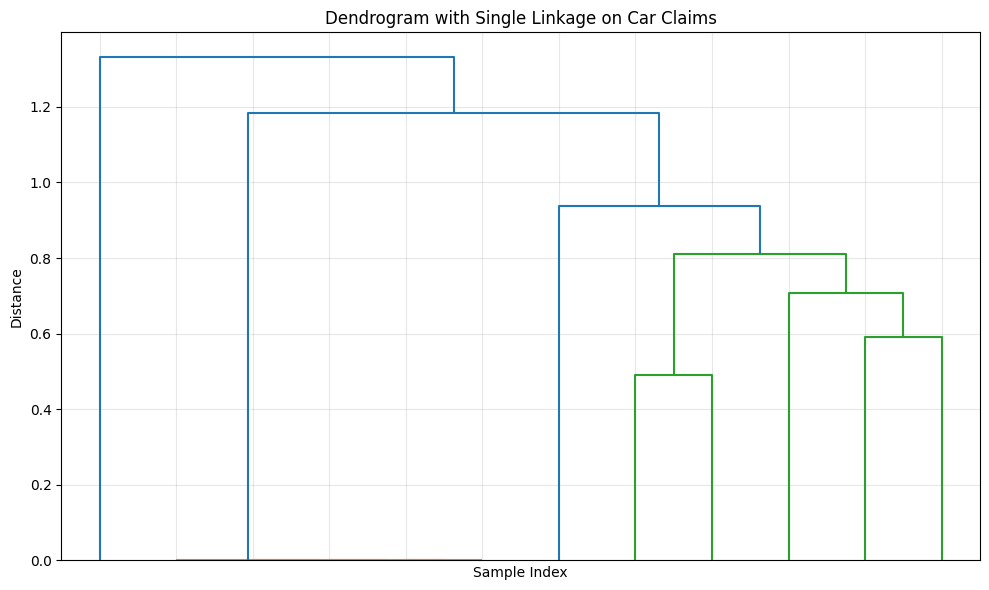

In [16]:
# HAC-single

# HAC clustering with different linkage methods
hac_single_car = AgglomerativeClustering(n_clusters=5, linkage='single')
labels_single_car = hac_single_car.fit_predict(X_train_car_oh_reg[['Age', 'Make']])

# Plot the clusters
plt.figure(figsize=(10,6))
sns.scatterplot(X_train_car_oh_reg, x='Age', y='Make', hue=labels_single_car, palette='Set1', style=labels_single_car, markers=["o", "s", "D", "X", "P"], alpha=0.7)
plt.xlabel("Age")
plt.ylabel("Make")
plt.title("HAC Clustering with Single Linkage")
plt.legend(title='Cluster', bbox_to_anchor=(1, 1), loc='upper left')
plt.grid(True, alpha=0.3)
plt.show()

# Compute the linkage matrix
linkage_matrix_single_car = linkage(X_train_car_oh_reg[['Age', 'Make']], method='single')

# Plot the dendrogram
plt.figure(figsize=(10, 6))
dendrogram(linkage_matrix_single_car, truncate_mode='level', p=5)
plt.title("Dendrogram with Single Linkage on Car Claims")
plt.xlabel("Sample Index")
plt.xticks(visible=False)
plt.ylabel("Distance")
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

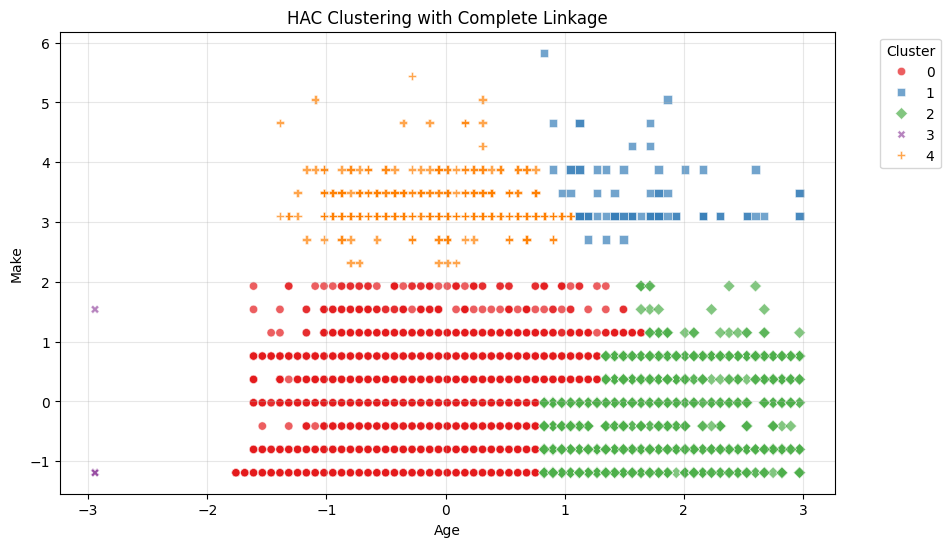

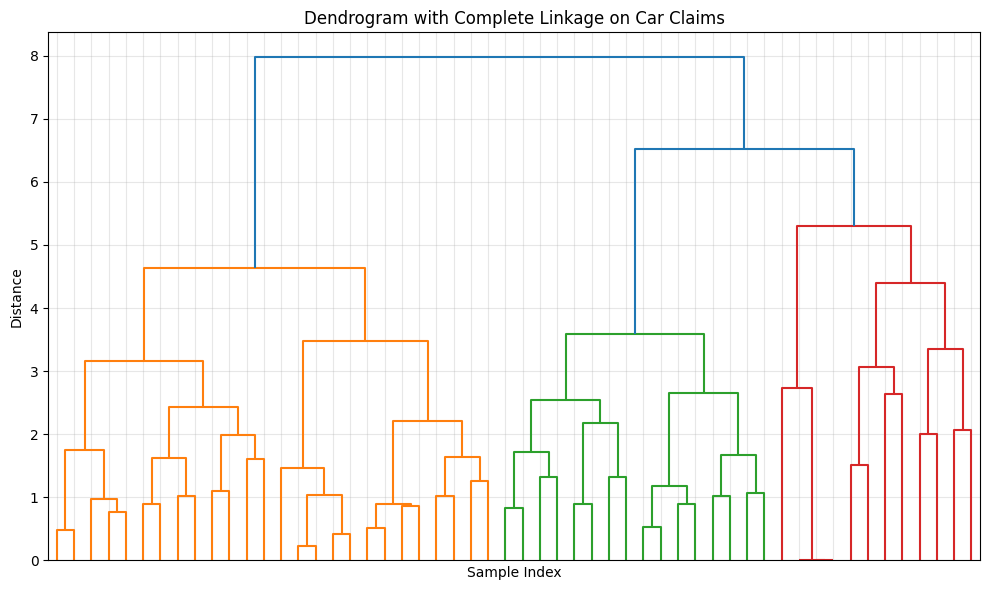

In [17]:
# HAC-Complete

# HAC clustering with different linkage methods
hac_complete_car = AgglomerativeClustering(n_clusters=5, linkage='complete')
labels_complete_car = hac_complete_car.fit_predict(X_train_car_oh_reg[['Age', 'Make']])

# Plot the clusters
plt.figure(figsize=(10,6))
sns.scatterplot(X_train_car_oh_reg, x='Age', y='Make', hue=labels_complete_car, palette='Set1', style=labels_complete_car, markers=["o", "s", "D", "X", "P"], alpha=0.7)
plt.xlabel("Age")
plt.ylabel("Make")
plt.title("HAC Clustering with Complete Linkage")
plt.legend(title='Cluster', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.grid(True, alpha=0.3)
plt.show()

# Compute the linkage matrix
linkage_matrix_complete_car = linkage(X_train_car_oh_reg[['Age', 'Make']], method='complete')

# Plot the dendrogram
plt.figure(figsize=(10, 6))
dendrogram(linkage_matrix_complete_car, truncate_mode='level', p=5)
plt.title("Dendrogram with Complete Linkage on Car Claims")
plt.xlabel("Sample Index")
plt.xticks(visible=False)
plt.ylabel("Distance")
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

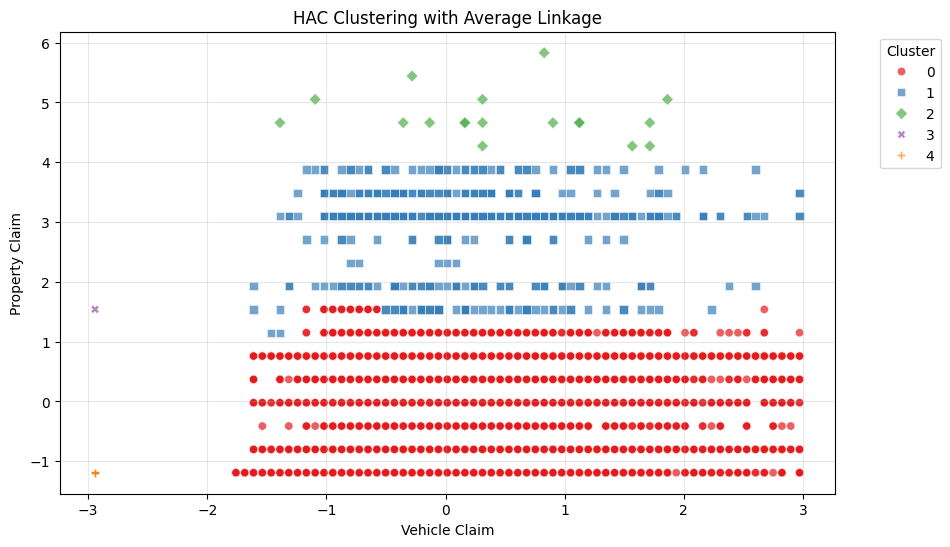

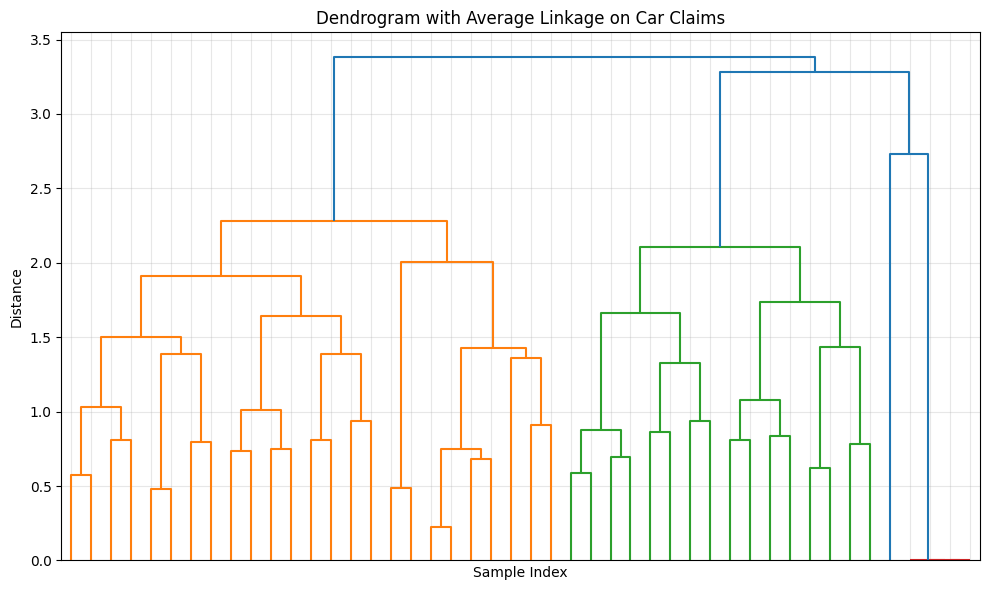

In [18]:
# HAC-Average

# HAC clustering with different linkage methods
hac_average_car = AgglomerativeClustering(n_clusters=5, linkage='average')
labels_average_car = hac_average_car.fit_predict(X_train_car_oh_reg[['Age', 'Make']])

# Plot the clusters
plt.figure(figsize=(10,6))
sns.scatterplot(X_train_car_oh_reg, x='Age', y='Make', hue=labels_average_car, palette='Set1', style=labels_average_car, markers=["o", "s", "D", "X", "P"], alpha=0.7)
plt.xlabel("Vehicle Claim")
plt.ylabel("Property Claim")
plt.title("HAC Clustering with Average Linkage")
plt.legend(title='Cluster', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.grid(True, alpha=0.3)
plt.show()

# Compute the linkage matrix
linkage_matrix_average_car = linkage(X_train_car_oh_reg[['Age', 'Make']], method='average')

# Plot the dendrogram
plt.figure(figsize=(10, 6))
dendrogram(linkage_matrix_average_car, truncate_mode='level', p=5)
plt.title("Dendrogram with Average Linkage on Car Claims")
plt.xlabel("Sample Index")
plt.xticks(visible=False)
plt.ylabel("Distance")
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

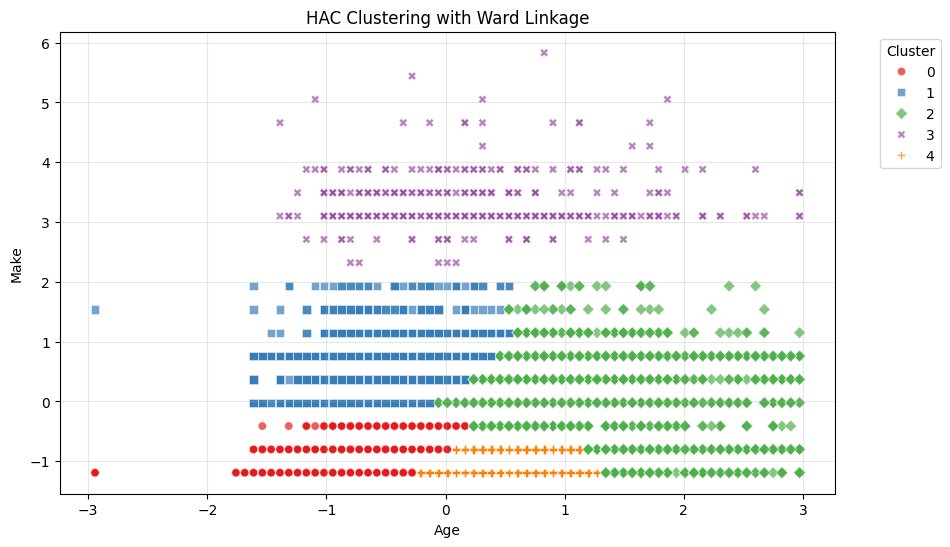

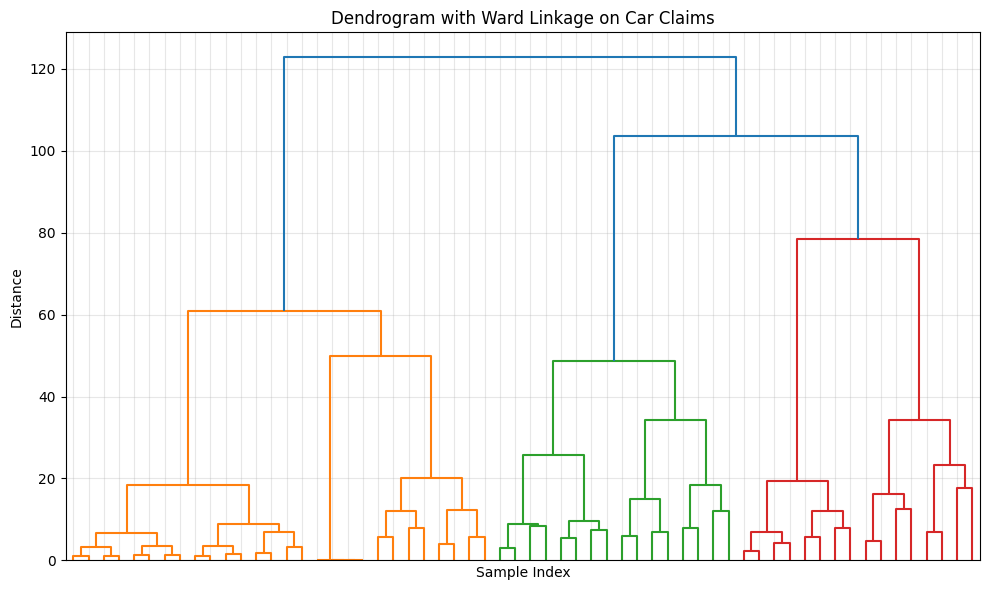

In [19]:
# HAC-Ward

# HAC clustering with different linkage methods
hac_ward_car = AgglomerativeClustering(n_clusters=5, linkage='ward')
labels_ward_car = hac_ward_car.fit_predict(X_train_car_oh_reg[['Age', 'Make']])

# Plot the clusters
plt.figure(figsize=(10,6))
sns.scatterplot(X_train_car_oh_reg, x='Age', y='Make', hue=labels_ward_car, palette='Set1', style=labels_ward_car, markers=["o", "s", "D", "X", "P"], alpha=0.7)
plt.xlabel("Age")
plt.ylabel("Make")
plt.title("HAC Clustering with Ward Linkage")
plt.legend(title='Cluster', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.grid(True, alpha=0.3)
plt.show()

# Compute the linkage matrix
linkage_matrix_ward_car = linkage(X_train_car_oh_reg[['Age', 'Make']], method='ward')

# Plot the dendrogram
plt.figure(figsize=(10, 6))
dendrogram(linkage_matrix_ward_car, truncate_mode='level', p=5)
plt.title("Dendrogram with Ward Linkage on Car Claims")
plt.xlabel("Sample Index")
plt.xticks(visible=False)
plt.ylabel("Distance")
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()